## Null Space of the attention mechanism

We consider the usual query/keys matrix for the $k$-th head defined as $Q^{(k)}=XW_{Q}^{(k)}+\boldsymbol{b}_Q^{(k)}$ and $K^{(k)}=XW_{K}^{(k)}+\boldsymbol{K}_Q^{(k)}$ where the weight matrices are $768\times 64$, the biases vectors $1\times 64$ and the tokens buffer is $N\times 768$. This matricies give the attention score for the $k$-th head $A_{N\times N}$, where each elements is given by:
$$A_{ij}^{(k)}\propto \braket{\boldsymbol{q}_i^{(k)},\boldsymbol{k}_j^{(k)}}=\braket{\boldsymbol{x}_i W_Q^{k}+\boldsymbol{b}_Q^{(k)},\boldsymbol{x}_j^{(k)}W_K^{k}+\boldsymbol{b}_K^{(k)}}$$
The weight metrices opearate a rank reduction from the original 768-dimensional embedding space to a smaller 64-dimansion subspace. This means that for specific tokens $\boldsymbol{x}$, the attention matrix remain invariant. If $\boldsymbol{v}\in\text{null}(W_Q)$ and $\boldsymbol{w}\in\text{null}(W_K)$, then:
$$A_{ij}^{(k)}(\boldsymbol{x}_i+\boldsymbol{v},\boldsymbol{x}_j+\boldsymbol{w})=A_{ij}^{(k)}(\boldsymbol{x}_i,\boldsymbol{x}_j)$$
these subspaces are at least $768-64=704$ dimensional and we can call them as the queries and keys **indifference space**, which is in direct sum with the **attention space**, which is at most a 64-dimensional subspace. A vector in the indifference space is ignored by a specific attention head, and correlation (topologiacal similarities, distance and overlap between indifference/attention manifolds) can give infermation about the behaviour of each attention head, whith the advantage to be token-agnostic. 

In [3]:
import numpy as np
from scipy.linalg import null_space, orth, svd, qr, subspace_angles
import matplotlib.pyplot as plt
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True)
model.eval()

embeddings = model.wte.weight.data

print("Model name:", model.config.name_or_path)
print("Tokenizer:", tokenizer.name_or_path)
print("Vocabulary size:", tokenizer.vocab_size)
print("Embedding dimensions:", model.config.hidden_size)
print("Number of attention layers:", model.config.num_hidden_layers)

Model name: gpt2
Tokenizer: gpt2
Vocabulary size: 50257
Embedding dimensions: 768
Number of attention layers: 12


In [100]:
state_dict = model.state_dict()

WQ = torch.empty(12, 12, 768, 64)
WK = torch.empty_like(WQ)

bQ = torch.empty(12, 12, 64)
bK = torch.empty_like(bQ)

for layer in range(12):
    # [768, 2304] → chunk into [768, 768] each
    _WQ, _WK, _ = state_dict[f'h.{layer}.attn.c_attn.weight'].chunk(3, dim=1)
    _bQ, _bK, _ = state_dict[f'h.{layer}.attn.c_attn.bias'].chunk(3, dim=0)

    _h_WQ = _WQ.chunk(12, dim=1)
    _h_WK = _WK.chunk(12, dim=1)
    _h_bQ = _bQ.chunk(12, dim=0)
    _h_bK = _bK.chunk(12, dim=0)

    for head in range(12):
        WQ[layer, head] = _h_WQ[head]
        WK[layer, head] = _h_WK[head]
        bQ[layer, head] = _h_bQ[head]
        bK[layer, head] = _h_bK[head]

In [10]:
layer = 0
head = 0

# Null space of Q and K (indifference basis)
null_Q = null_space(WQ[layer, head].T)
null_K = null_space(WK[layer, head].T)

# Column space of Q and K (attention basis)
rank_Q = orth(WQ[layer, head])
rank_K = orth(WK[layer, head])

print("HEAD {} of LAYER {}:".format(head, layer))
print("Null space dimensions for Q:", null_Q.shape[1])
print("Null space dimensions for K:", null_K.shape[1])


HEAD 0 of LAYER 0:
Null space dimensions for Q: 704
Null space dimensions for K: 704


Angles close to 0° indicate shared vectors: 64
Angles close to 90° indicate orthogonal vectors: 640


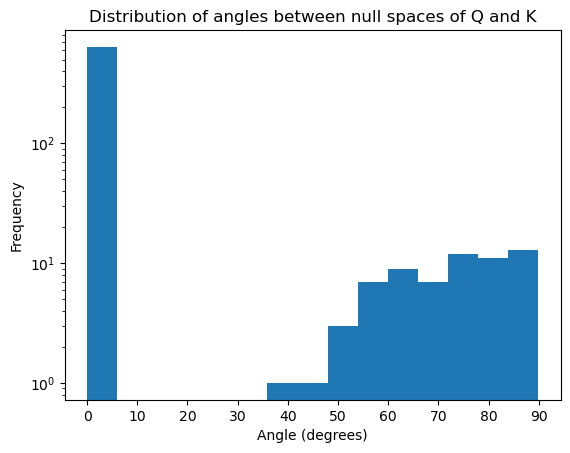

In [11]:
angles = subspace_angles(null_Q, null_K)
angles_deg = np.degrees(angles)

print("Angles close to 0° indicate shared vectors:", len(angles_deg[angles_deg > 20]))
print("Angles close to 90° indicate orthogonal vectors:", len(angles_deg[angles_deg < 20]))

plt.hist(angles_deg, bins=15)
plt.title("Distribution of angles between null spaces of Q and K")
plt.xlabel("Angle (degrees)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xticks(np.arange(0, 91, 10))
plt.show()

In [17]:
grassmann_distance = np.sqrt(np.sum(angles**2))
print("Grassmann distance between null spaces of Q and K:", grassmann_distance)

Grassmann distance between null spaces of Q and K: 9.966511


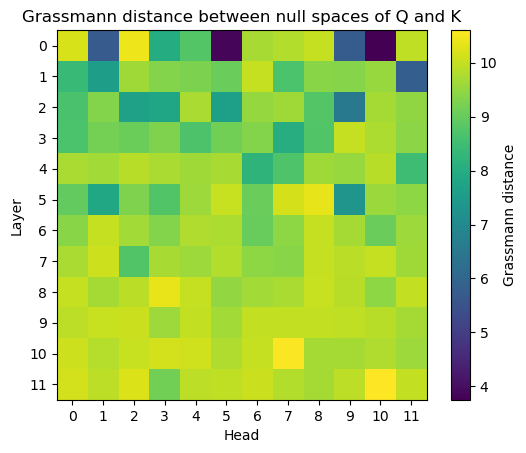

In [104]:
grassman = np.zeros((12, 12))

for layer in range(12):
    for head in range(12):
        null_Q = null_space(WQ[layer, head].T)
        null_K = null_space(WK[layer, head].T)
        angles = subspace_angles(null_Q, null_K)
        grassmann_distance = np.sqrt(np.sum(angles**2))
        grassman[layer, head] = grassmann_distance

plt.imshow(grassman, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Grassmann distance')
plt.title("Grassmann distance between null spaces of Q and K")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.xticks(np.arange(12), np.arange(12))
plt.yticks(np.arange(12), np.arange(12))
plt.show()

In [ ]:
indifference = null_space(np.concatenate([WQ[0, 0].T, WK[0, 0].T]))

array([[ 2.1592271e-02,  1.6640887e-02,  4.5998497e-03, ...,
        -1.2685591e-02,  2.3436375e-02, -5.0235700e-02],
       [ 1.8599235e-02,  1.5895339e-02,  4.9626812e-02, ...,
        -5.7309316e-03, -6.0654700e-02,  1.1493431e-02],
       [-1.2940826e-02,  9.0178736e-02,  5.1101632e-02, ...,
        -2.0534413e-02, -1.7344108e-02,  1.1215743e-02],
       ...,
       [ 9.7847097e-03, -1.4464435e-02, -1.2270894e-02, ...,
         8.3862764e-01, -1.3829919e-02,  4.1392851e-03],
       [-1.0253129e-03, -4.9387169e-04, -1.6067931e-02, ...,
        -7.5266343e-03,  8.2931077e-01, -1.3318659e-03],
       [ 6.0287461e-04,  8.8705756e-03,  1.4458900e-02, ...,
         1.6080454e-02,  1.0907729e-03,  8.0737275e-01]],
      shape=(768, 640), dtype=float32)

Grassmann distance between heads 0 and 1 for the layer 0: 13.490689


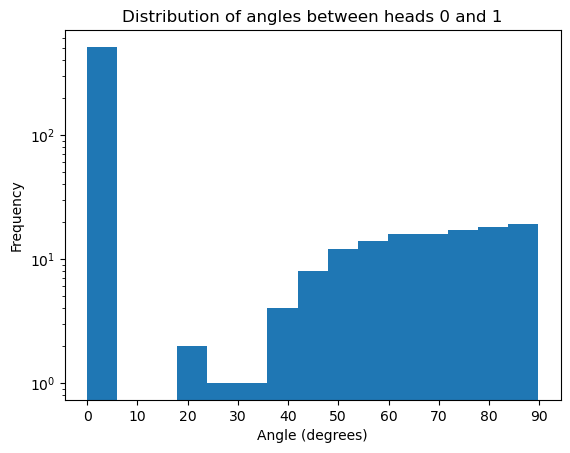

In [149]:
# common basis for the null space of Q and K (attention head)
layer = 0
heads = (0, 1)

indifference_i = null_space(np.concatenate([WQ[layer, heads[0]].T, WK[layer, heads[0]].T]))
indifference_j = null_space(np.concatenate([WQ[layer, heads[1]].T, WK[layer, heads[1]].T]))

angles = subspace_angles(indifference_i, indifference_j)
angles_deg = np.degrees(angles)

print("Grassmann distance between heads {} and {} for the layer {}:".format(heads[0], heads[1], layer), np.sqrt(np.sum(angles**2)))

plt.hist(angles_deg, bins=15)
plt.title("Distribution of angles between heads {} and {}".format(heads[0], heads[1]))
plt.xlabel("Angle (degrees)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xticks(np.arange(0, 91, 10))
plt.show()

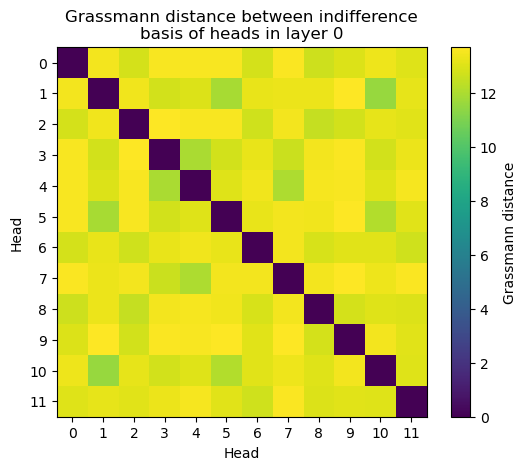

In [210]:
layer = 0

layers_indiff = []
for head in range(12):
    indifference = null_space(np.concatenate([WQ[layer, head].T, WK[layer, head].T]))
    layers_indiff.append(indifference)

grassman = np.zeros((12, 12))

for i in range(12):
    for j in range(12):
        if i > j:
            angles = subspace_angles(layers_indiff[i], layers_indiff[j])
            grassman[i, j] = np.sqrt(np.sum(angles**2))
            grassman[j, i] = grassman[i, j]

plt.imshow(grassman, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Grassmann distance')
plt.title("Grassmann distance between indifference\nbasis of heads in layer {}".format(layer))
plt.xlabel("Head")
plt.ylabel("Head")
plt.xticks(np.arange(12), np.arange(12))
plt.yticks(np.arange(12), np.arange(12))
plt.show()

In [208]:
grassmann_layers = []
for layer in range(12):
    print(f"Processing layer {layer}")
    layers_att = []
    for head in range(12):
        attention_space = orth(np.concatenate([WQ[layer, head], WK[layer, head]]))
        layers_att.append(attention_space)

    grassman = np.zeros((12, 12))

    for i in range(12):
        for j in range(12):
            if i > j:
                angles = subspace_angles(layers_att[i], layers_att[j])
                grassman[i, j] = np.sqrt(np.sum(angles**2))
                grassman[j, i] = grassman[i, j]
    
    grassmann_layers.append(grassman)

Processing layer 0
Processing layer 1
Processing layer 2
Processing layer 3
Processing layer 4
Processing layer 5
Processing layer 6
Processing layer 7
Processing layer 8
Processing layer 9
Processing layer 10
Processing layer 11


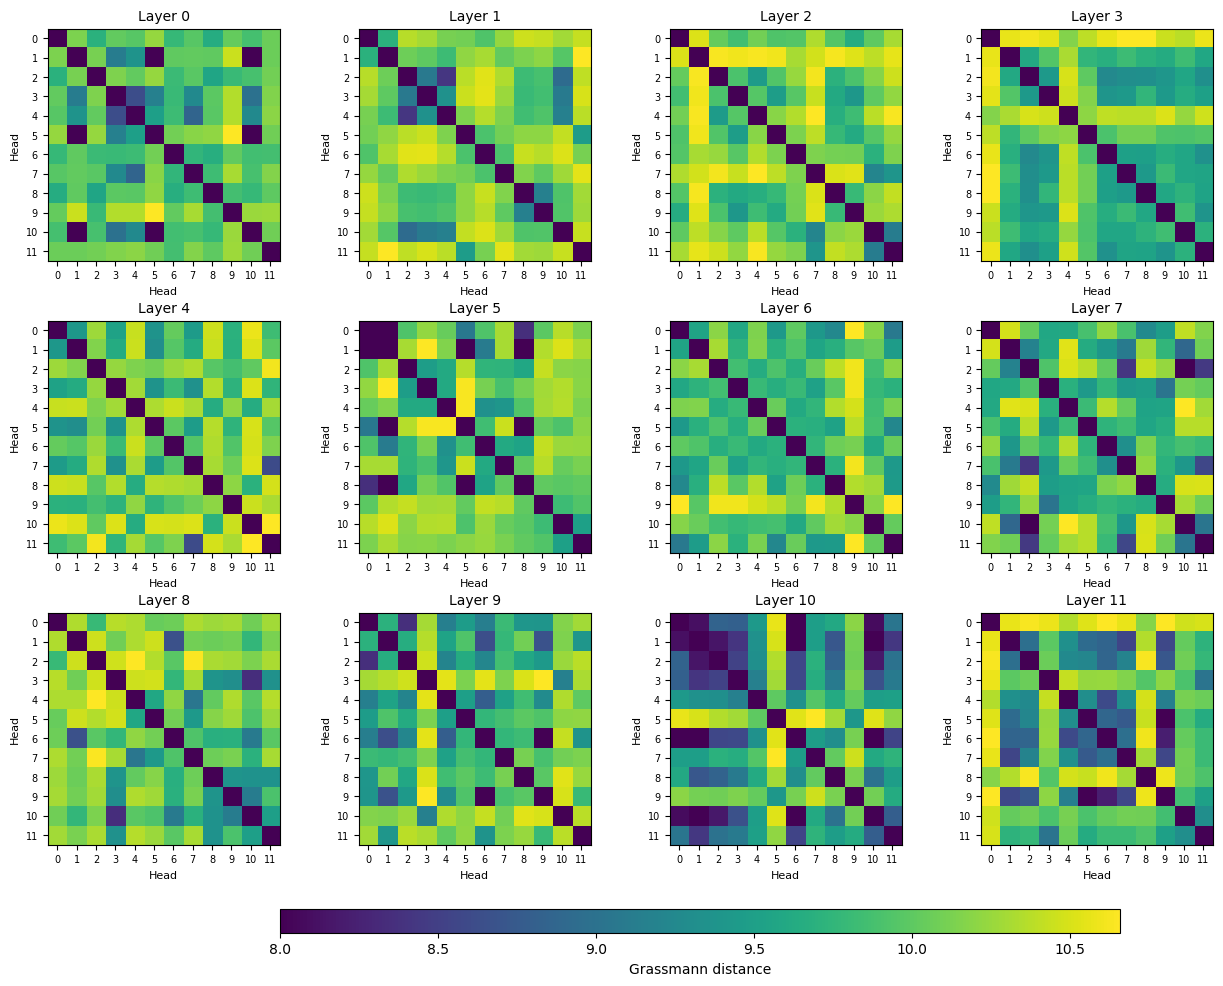

In [212]:
treshold = 8 # threshold for visualization

fig, axes = plt.subplots(3, 4, figsize=(14, 8))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(grassmann_layers[i], cmap='viridis', interpolation='nearest', vmin=treshold)
    ax.set_title(f"Layer {i}", fontsize=10)
    ax.set_xlabel("Head", fontsize=8)
    ax.set_ylabel("Head", fontsize=8)
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(12))
    ax.tick_params(axis='both', which='major', labelsize=7)

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
cbar_ax = fig.add_axes([0.2, -0.03, 0.6, 0.03])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Grassmann distance')
plt.subplots_adjust(left=0, right=0.9, top=1.1, bottom=0.08)
plt.show()